In [1]:
import numpy as np
from matplotlib import pyplot as plt
import camb
import pygtc
import time

In [2]:
# def fisher(p,unc,dpar,nmodes):
#     '''
#     p      = vector of cosmological parameters (npar x 1)
#     unc    = vector of uncertainties (n_kmodes x 1)
#     dpar   = vector (you might want dif step sizes for dif params) of step sizes (npar x 1)
#     nmodes = [scalar] number of modes in the spectrum - could be l-modes for CMB, k-modes for 21 cm, etc.
#     '''
#     nprm=len(p)
#     V=np.zeros((nmodes,nprm))
#     for par in range(nprm):
#         V[:,par]=CAMBpartial(p,par,dpar)/unc
#     return V.T@V

def build_partials(p,unc,dpar,nmodes):
    '''
    p      = vector of cosmological parameters (npar x 1)
    unc    = vector of uncertainties (n_kmodes x 1)
    dpar   = vector (you might want dif step sizes for dif params) of step sizes (npar x 1)
    nmodes = [scalar] number of modes in the spectrum - could be l-modes for CMB, k-modes for 21 cm, etc.
    '''
    nprm=len(p)
    V=np.zeros((nmodes,nprm))
    for par in range(nprm):
        V[:,par]=CAMBpartial(p,par,dpar)
    return V

def fisher(partials,unc):
    '''
    partials = nmodes x nprm array where each column is an nmodes x 1 vector of the PS's partial WRT a dif param
    unc      = nmodes x 1 vector of standard deviations at each mode (could be k-mode, l-mode, etc.)
    '''
    nmodes,nprm=partials.shape
    V=np.zeros((nmodes,nprm))
    for i in range(nprm):
        V[:,i]=partials[:,i]/unc
    return V.T@V

scale=1e-9
def get_spectrum(pars,lmax=3000):
    '''
    pars = vector of cosmological parameters (npar x 1)
    lmax = maximum number angular mode
    '''
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]*scale # good
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]
    return tt[2:]

def CAMBpartial(p,n,dpar):
    '''
    p    = vector of cosmological parameters (npar x 1)
    n    = take the partial derivative WRT the nth parameter in p
    dpar = vector (you might want dif step sizes for dif params) of step sizes (npar x 1)
    '''
    nprm=len(p)
    model=get_spectrum(p) # model should be get_spec for the unperturbed params
    npts=len(model)
    Ap=np.zeros([npts,1])
    pcopy=p.copy()
    pcopy[n]=pcopy[n]+dpar[n]
    fplus=get_spectrum(pcopy)[:npts]
    pcopy=p.copy()
    pcopy[n]=pcopy[n]-dpar[n]
    fminu=get_spectrum(pcopy)[:npts]
    return ((fplus-fminu)/(2*dpar[n])).reshape((npts,))

In [3]:
p0=np.asarray([67.7,0.022,0.119,0.056,2.1e-9, 0.97])
p0[4]/=scale
nprm=len(p0) # number of parameters
dpar=1e-3*np.ones(nprm)
dpar[4]*=scale
spec0=get_spectrum(p0)

n_lmodes=len(spec0)
p0_tuple=tuple(p0) # tuple version to keep pyGTC happy

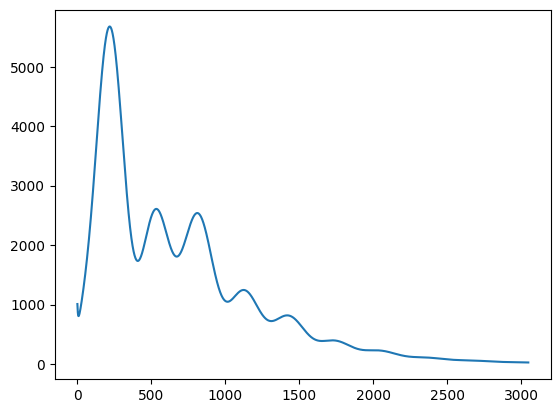

In [4]:
plt.figure()
plt.plot(spec0)
plt.show()

In [5]:
INITIAL=False
if INITIAL:
    nmodes0=len(spec0)
    t0=time.time()
    partials=build_partials(p0,unc,dpar,nmodes0)
    t1=time.time()
    print('calculating the PS partials took',t1-t0,'s')
    np.savetxt('camb_partials.txt',partials)
else: 
    partials=np.genfromtxt('camb_partials.txt')

In [13]:
alpha=0.5
unc=alpha*spec0 # this says that the precision at each l-mode is alpha times the simulated spectrum value
fish=fisher(partials,unc)

pnames=['$H_0$','$\Omega_b h^2$','$\Omega_c h^2$','$\\tau$','$A_S$','$n_s$']
mean=np.zeros(nprm)
nsamp=10000
cov=np.linalg.inv(fish)
samps=np.random.multivariate_normal(mean,cov,size=nsamp)

print(len(p0_tuple),len(pnames))

GTC=pygtc.plotGTC(chains=samps,
                  paramNames=pnames,
#                   truths=p0,
                  truths=p0_tuple,
                  truthLabels=pnames,
                  plotName='CAMB_angular_alpha.pdf')

6 6


AssertionError: truthLabels mismatch with number of truths

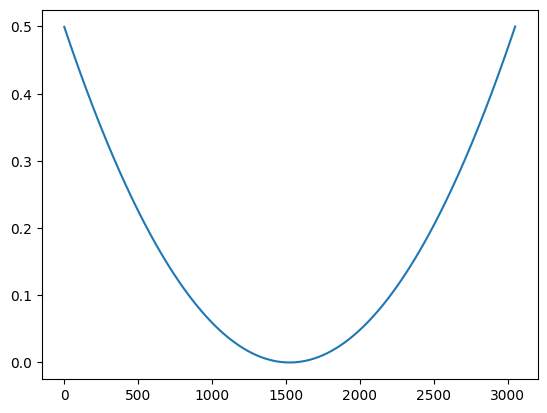

(10000, 6)


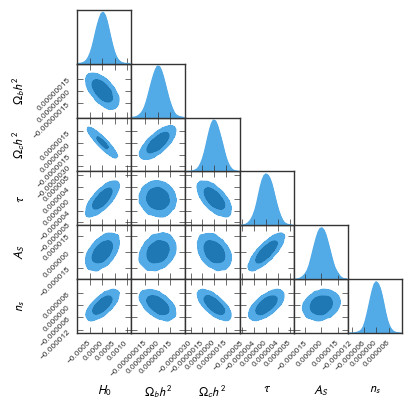

In [7]:
alpha=0.5
unc_x=np.arange(1,n_lmodes+1)
unc=(unc_x-n_lmodes/2)**2 # this says that the precision at each l-mode is alpha times the simulated spectrum value
unc/=(unc.max()/alpha)
plt.figure()
plt.plot(unc_x,unc)
plt.show()
fish=fisher(partials,unc)

pnames=['$H_0$','$\Omega_b h^2$','$\Omega_c h^2$','$\\tau$','$A_S$','$n_s$']
mean=np.zeros(nprm)
nsamp=10000
cov=np.linalg.inv(fish)
samps=np.random.multivariate_normal(mean,cov,size=nsamp)
print(samps.shape)
GTC=pygtc.plotGTC(chains=samps,
                  paramNames=pnames,
                  truths=p0,
#                   truths=p0_tuple,
                  plotName='CAMB_angular_parabola.pdf')

In [8]:
print(fish)

[[ 1.30855506e+17 -1.53876608e+20  5.16139476e+19  1.15953802e+19
  -2.74520155e+18 -5.21054906e+18]
 [-1.53876608e+20  1.80948298e+23 -6.06943247e+22 -1.36353959e+22
   3.22817129e+21  6.12725625e+21]
 [ 5.16139476e+19 -6.06943247e+22  2.03583360e+22  4.57362701e+21
  -1.08280401e+21 -2.05522406e+21]
 [ 1.15953802e+19 -1.36353959e+22  4.57362701e+21  1.02749943e+21
  -2.43259680e+20 -4.61721127e+20]
 [-2.74520155e+18  3.22817129e+21 -1.08280401e+21 -2.43259680e+20
   5.75915556e+19  1.09312129e+20]
 [-5.21054906e+18  6.12725625e+21 -2.05522406e+21 -4.61721127e+20
   1.09312129e+20  2.07480810e+20]]
